# Step 1: Import the required libraries

In [52]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.ma.core import size
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Step 2: Load and prepare the data

In [33]:
# Starting point : When Bitcoin firstly was showed on Yahoo Finance Chart
# First, I will looking into "S&P500(^GSPC)" Price. After analyzing it, I will apply this metrics to the other investment assets. 

start = "2014-09-17"
end = "2024-02-14"
symbol = {"^GSPC"}
data = yf.download(symbol, start, end, auto_adjust=True)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,1999.300049,2010.739990,1993.290039,2001.569946,3209420000
2014-09-18,2003.069946,2012.339966,2003.069946,2011.359985,3235340000
2014-09-19,2012.739990,2019.260010,2006.589966,2010.400024,4880220000
2014-09-22,2009.079956,2009.079956,1991.010010,1994.290039,3349670000
2014-09-23,1992.780029,1995.410034,1982.770020,1982.770020,3279350000
...,...,...,...,...,...
2024-02-07,4973.049805,4999.890137,4969.049805,4995.060059,4895590000
2024-02-08,4995.160156,5000.399902,4987.089844,4997.910156,4341860000
2024-02-09,5004.169922,5030.060059,5000.339844,5026.609863,3912990000


In [34]:
# Checking Missing Values : No
data.isna().sum()/len(data)

Open      0.0
High      0.0
Low       0.0
Close     0.0
Volume    0.0
dtype: float64

In [35]:
# Only use 'Close'
SnP = data['Close']
SnP.head()

Date
2014-09-17    2001.569946
2014-09-18    2011.359985
2014-09-19    2010.400024
2014-09-22    1994.290039
2014-09-23    1982.770020
Name: Close, dtype: float64

In [36]:
# Taking log
SnP_log = np.log(SnP)

# Step 3: Visualise the data and conduct the ADF test

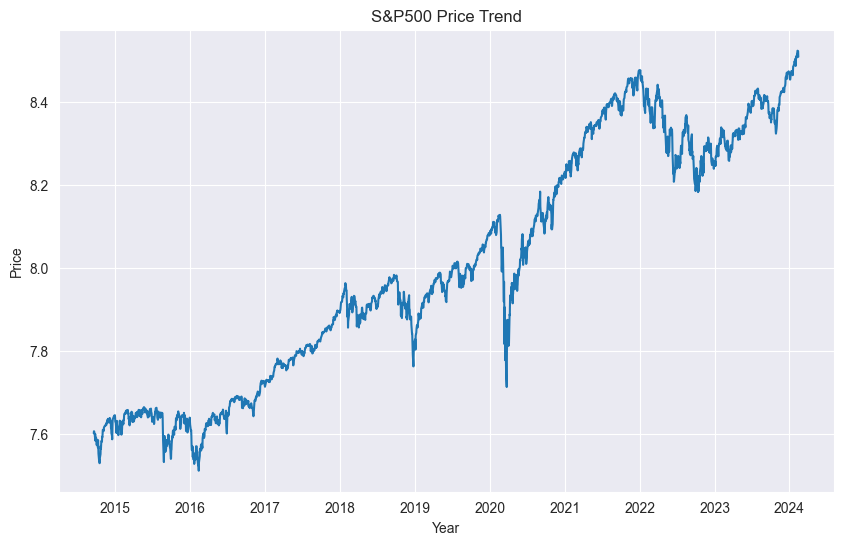

In [81]:
# Plot the time series data to understand its patterns and trends

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title("S&P500 Price Trend")
plt.plot(SnP_log)


In [38]:
# If data is not stationary according to the ADF test, it has to be converted into a stationary data for building up Machine Learning Model.
# Define a function to perform the Augmented Dickey-Fuller (ADF) test

def augmented_dickey_fuller_test(timeseries):
    # Perform the ADF test
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # Print the results
    print('Results of Dickey-Fuller Test:')
    # Create a pandas Series to display the test statistics, p-value, number of lags used, and number of observations used
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    # Add critical values to the Series
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    # Print the Series containing test results
    print(dfoutput)
    
    # Determine stationarity
    if dftest[1] > 0.05:
        print("Is Stationary: No (fail to reject)")
    else:
        print("Is Stationary: Yes (reject)")

# Call the function to perform the ADF test
print(augmented_dickey_fuller_test(SnP_log))

Results of Dickey-Fuller Test:
Test Statistic                   -0.633549
p-value                           0.863220
#Lags Used                       10.000000
Number of Observations Used    2357.000000
Critical Value (1%)              -3.433127
Critical Value (5%)              -2.862767
Critical Value (10%)             -2.567423
dtype: float64
Is Stationary: No (fail to reject)
None


# Step 4: Time Series Data Decomposition

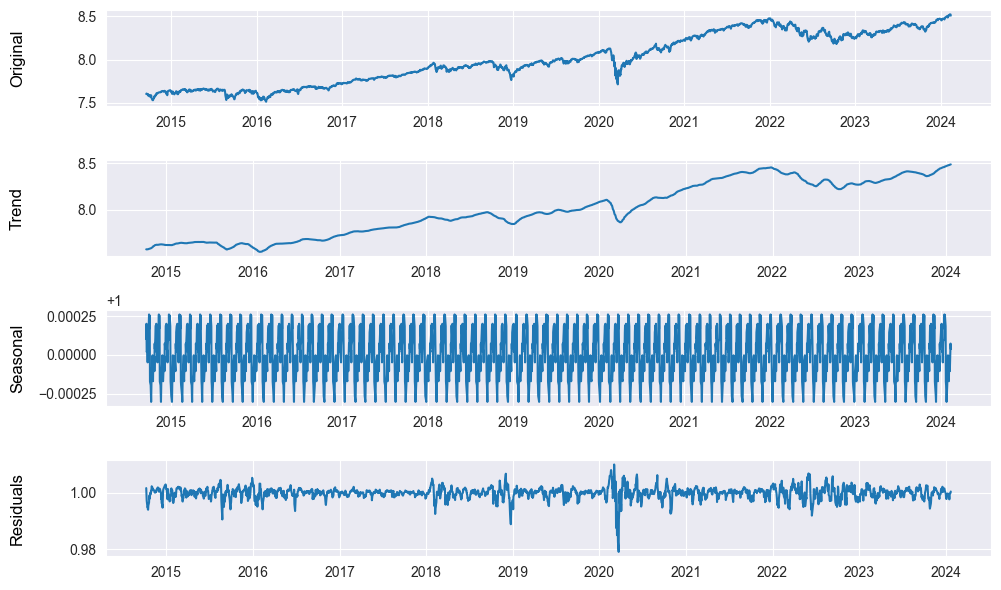

In [39]:
# Perform Time Series Data Decomposition since it helps in understanding the underlying structure and preparing the data for further analysis or modeling.

decomposition = seasonal_decompose(SnP_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 6))
# Original
plt.subplot(411)
plt.plot(SnP_log, label='original')
plt.annotate('Original', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Trend
plt.subplot(412)
plt.plot(trend, label='trend')
plt.annotate('Trend', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Seasonality
plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.annotate('Seasonal', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Residuals
plt.subplot(414)
plt.plot(residual, label='residuals')
plt.annotate('Residuals', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

plt.tight_layout()
plt.show()

In [79]:
# Check the trend's staionary after decomposition : NO

trend.dropna(inplace=True)
augmented_dickey_fuller_test(trend)

Results of Dickey-Fuller Test:
Test Statistic                   -0.039360
p-value                           0.955153
#Lags Used                       27.000000
Number of Observations Used    2310.000000
Critical Value (1%)              -3.433184
Critical Value (5%)              -2.862792
Critical Value (10%)             -2.567437
dtype: float64
Is Stationary: No (fail to reject)


# Step 5: Converting non-stationary into stationary data

<Axes: xlabel='Date'>

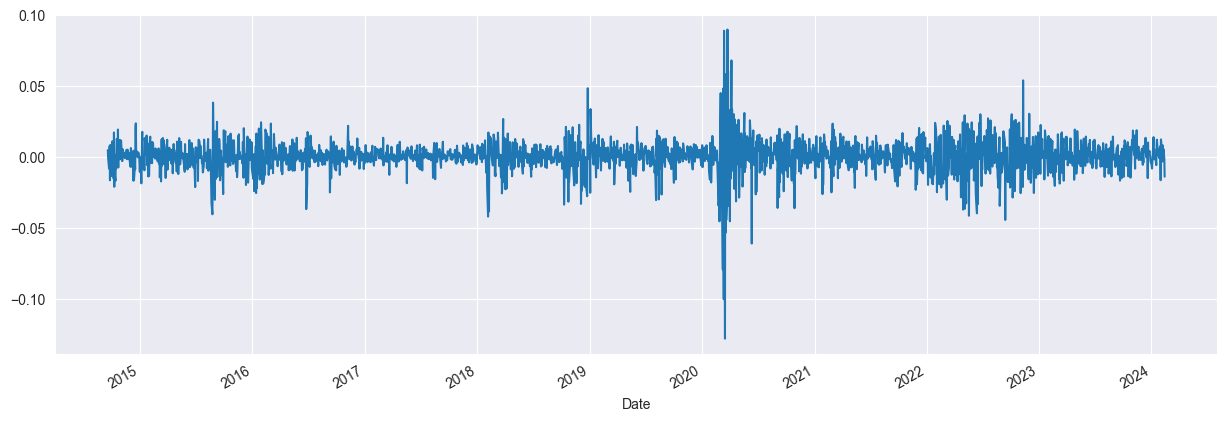

In [80]:
# The is non-stationary, which is evident in the trend itself, but it is always good to verify things. 
# So I need to apply some operations to make the series stationary by differencing

SnP_diff = SnP_log.diff().dropna()
SnP_diff.plot(figsize=(15,5))

In [82]:
# ADF test after differencing : Stationary

augmented_dickey_fuller_test(SnP_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.523167e+01
p-value                        5.310876e-28
#Lags Used                     9.000000e+00
Number of Observations Used    2.357000e+03
Critical Value (1%)           -3.433127e+00
Critical Value (5%)           -2.862767e+00
Critical Value (10%)          -2.567423e+00
dtype: float64
Is Stationary: Yes (reject)


# Step 6: Splitting Train-Test data

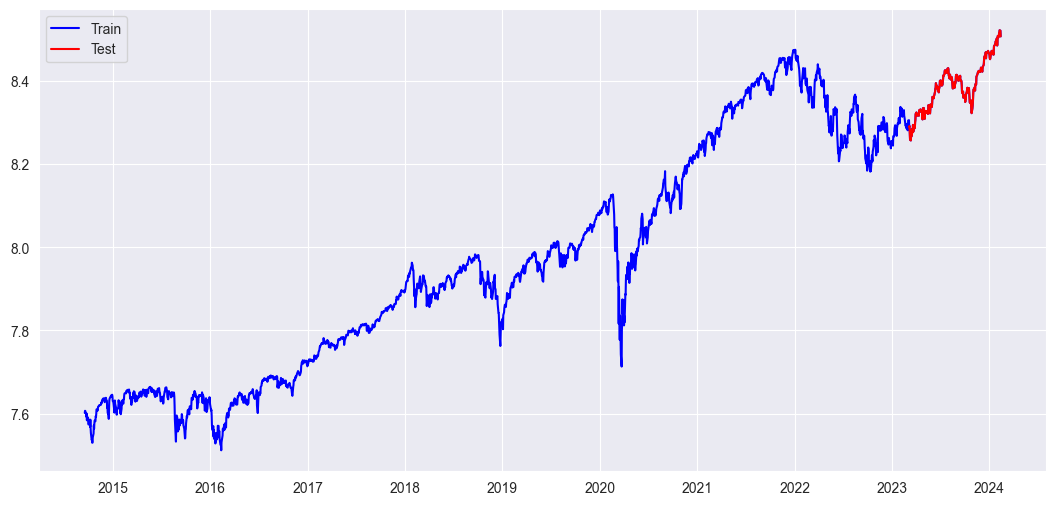

In [84]:
# Here, I am splitting train test data by the ratio of 8:2. Let’s Visualize the data after splitting.
# Split Train / Test dataset by 9:1

train_size = int(len(SnP_log) * 0.9)
train = SnP_log.iloc[:train_size]
test = SnP_log.iloc[train_size:]

# Visualization of splitting
plt.figure(figsize=(13,6))
plt.grid(True)
plt.plot(SnP_log, c='b', label='Train') 
plt.plot(test, c='r', label='Test')
plt.legend()


# Step 7: Apply 'auto_ARIMA' function

In [85]:
# Find the optimal parameters
model = pm.auto_arima(
            y=SnP_log,  
            start_p=0, max_p=3, 
            start_q=0, max_q=3, 
            m=1, seasonal=False, 
            stepwise=True,
            trace=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14438.036, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14482.736, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14476.356, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14437.392, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14491.717, Time=0.78 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-14489.810, Time=0.73 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-14489.630, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14485.770, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-14487.688, Time=0.84 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-14490.666, Time=0.22 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 4.724 seconds


In [86]:
# Implementing ARIMA(2,1,0) model with the optimal parameters
model = ARIMA(train, order=(2,1,0))
results_ARIMA = model.fit()
print(results_ARIMA.summary())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2131
Model:                 ARIMA(2, 1, 0)   Log Likelihood                6463.739
Date:                Thu, 15 Feb 2024   AIC                         -12921.479
Time:                        00:48:45   BIC                         -12904.487
Sample:                             0   HQIC                        -12915.260
                               - 2131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1373      0.009    -15.446      0.000      -0.155      -0.120
ar.L2          0.0721      0.008      8.717      0.000       0.056       0.088
sigma2         0.0001   1.59e-06     84.905      0.0

Start Date: 2024-02-14 00:00:00
End Date: 2024-05-13 00:00:00
            Prediction
2024-02-14         NaN
2024-02-15         NaN
2024-02-16         NaN
2024-02-17         NaN
2024-02-18         NaN


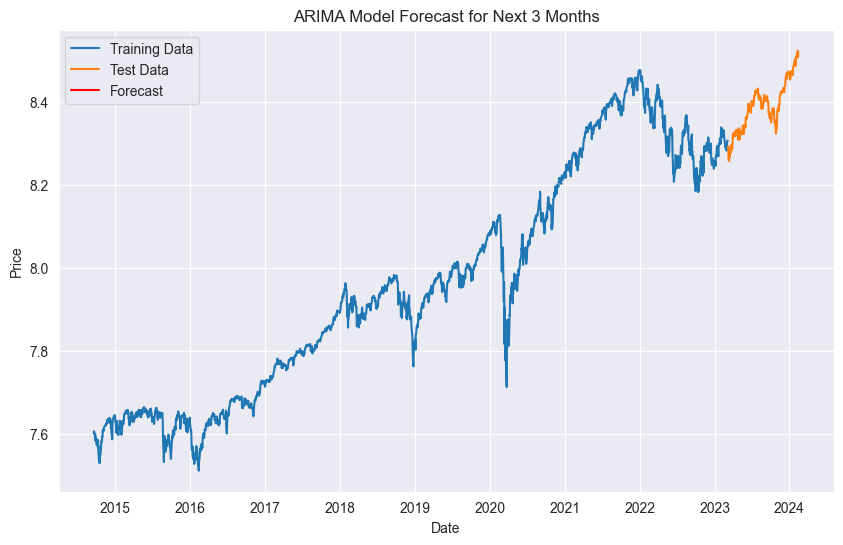

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

# 예측 시작 시점과 예측 기간 계산
start_date = test.index[-1] + pd.DateOffset(days=1)  # 테스트 데이터의 다음 날짜부터 시작
end_date = start_date + pd.DateOffset(days=len(predictions_3_months) - 1)  # 예측값 개수만큼의 기간 설정

# 날짜 범위 확인
print("Start Date:", start_date)
print("End Date:", end_date)

# 예측값과 해당 시간 인덱스를 포함하는 데이터프레임 생성
forecast_df = pd.DataFrame({'Prediction': predictions_3_months}, index=pd.date_range(start=start_date, periods=len(predictions_3_months), freq='D'))

# 데이터프레임 확인
print(forecast_df.head())

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(forecast_df.index, forecast_df['Prediction'], label='Forecast', color='red')
plt.title('ARIMA Model Forecast for Next 3 Months')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()



In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# MSE 계산
mse = mean_squared_error(test, predictions)

# MAE 계산
mae = mean_absolute_error(test, predictions)

# RMSE 계산
rmse = np.sqrt(mse)

# MAPE 계산
mape = np.mean(np.abs((test - predictions) / test)) * 100

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)



MSE: 0.010183596995148776
MAE: 0.08526545322502388
RMSE: 0.10091380973458873


/var/folders/ll/22q89fv95hbb3yt5tf_x_5lc0000gp/T/ipykernel_54478/4294530730.py:14: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - predictions) / test)) * 100


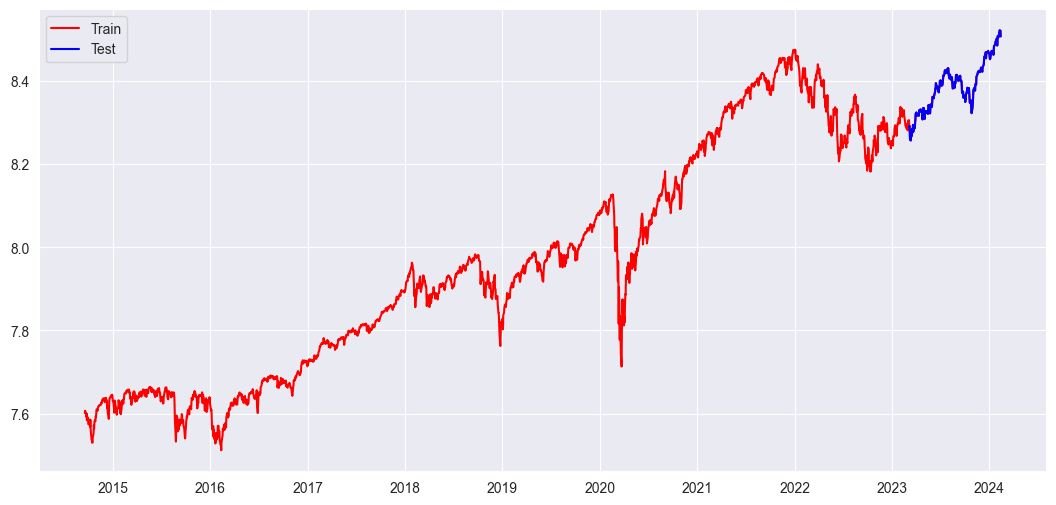

In [43]:
# Here, I am splitting train test data by the ratio of 8:2. Let’s Visualize the data after splitting.
# Split Train / Test dataset by 9:1

train_data, test_data = SnP_log[:int(len(SnP_log)*0.9)], SnP_log[int(len(SnP_log)*0.9):]

plt.figure(figsize=(13,6))
plt.grid(True)
plt.plot(SnP_log, c='r', label='Train') 
plt.plot(test_data, c='b', label='Test')
plt.legend()

# Step 6: Train-Test data Split

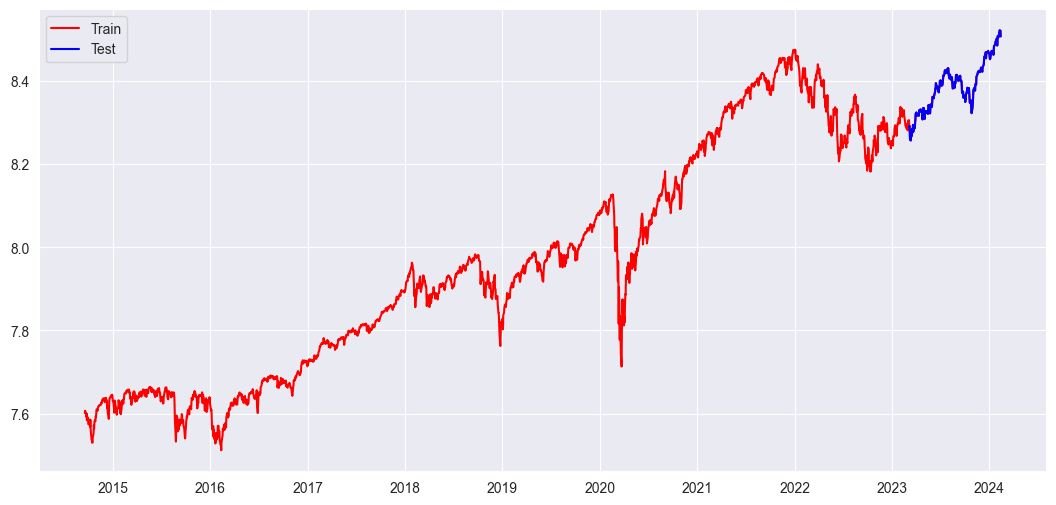

In [53]:
# Here, I am splitting train test data by the ratio of 8:2. Let’s Visualize the data after splitting.
# Split Train / Test dataset by 9:1

train_data, test_data = SnP_log[:int(len(SnP_log)*0.9)], SnP_log[int(len(SnP_log)*0.9):]

plt.figure(figsize=(13,6))
plt.grid(True)
plt.plot(SnP_log, c='r', label='Train') 
plt.plot(test_data, c='b', label='Test')
plt.legend()

In [54]:
# Now, I apply auto_arima function to the data because it helps to find an optimal order for an ARIMA model. 
# The function returns an fitted ARIMA model.

model_autoARIMA = auto_arima(SnP_log, 
                              start_p=0,
                              start_q=0,
                              max_p=7,
                              max_q=7,
                              m=1,
                              d=1,
                              seasonal=False,
                              start_P=0,
                              D=0,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14438.036, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14482.736, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14476.356, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14437.392, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14491.717, Time=0.84 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-14489.810, Time=0.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-14489.630, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14485.770, Time=0.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-14487.688, Time=0.87 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-14490.666, Time=0.22 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 4.783 seconds


# Step 8: ARIMA Model

In [74]:
# Build and Train  Model (p, d, q)
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit()  

# 최종 예측 모델 정확도 측정(MAPE)
print(fitted_m.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2131
Model:                 ARIMA(1, 2, 0)   Log Likelihood                6030.878
Date:                Thu, 15 Feb 2024   AIC                         -12057.755
Time:                        00:26:58   BIC                         -12046.428
Sample:                             0   HQIC                        -12053.609
                               - 2131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6049      0.007    -87.563      0.000      -0.618      -0.591
sigma2         0.0002   2.16e-06     93.711      0.000       0.000       0.000
Ljung-Box (L1) (Q):                  89.46   Jarque-

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


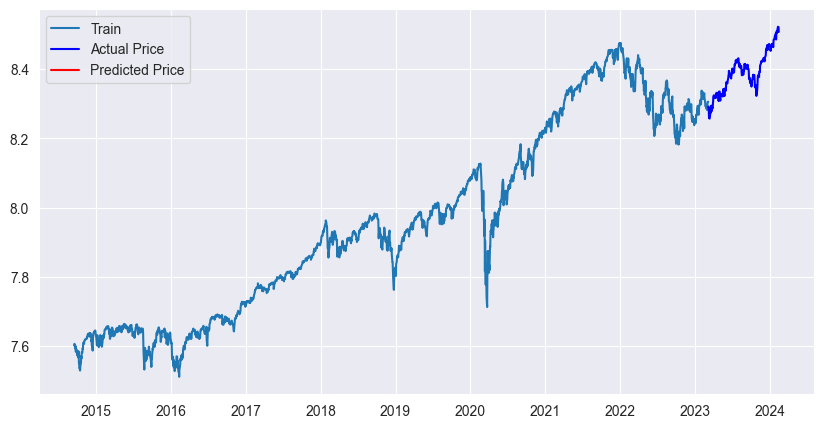

In [75]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data))  # 예측값만 가져옵니다.

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, c='b', label='Actual Price')
plt.plot(fc_series, c='r',label='Predicted Price')

plt.legend()
plt.show()


In [62]:
fc_series

Date
2023-03-07   NaN
2023-03-08   NaN
2023-03-09   NaN
2023-03-10   NaN
2023-03-13   NaN
              ..
2024-02-07   NaN
2024-02-08   NaN
2024-02-09   NaN
2024-02-12   NaN
2024-02-13   NaN
Name: predicted_mean, Length: 237, dtype: float64

In [25]:
# 모델의 오차율 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('\033[31m'+'\033[1m' + 'MSE: ' + '\033[0m', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('\033[31m'+'\033[1m' + 'MAE: ' + '\033[0m', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('\033[31m'+'\033[1m' + 'RMSE: ' + '\033[0m', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('\033[31m'+'\033[1m' + 'MAPE: ' + '\033[0m'+ '{:.2f}%'.format(mape*100))

MSE:  194048.89898403516
MAE:  368.13029729500477
RMSE:  440.50981712560633
MAPE: nan%


/var/folders/ll/22q89fv95hbb3yt5tf_x_5lc0000gp/T/ipykernel_54478/4069143015.py:14: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))


# Step 9: Model Predictions

In [151]:
test.shape

(483,)

In [153]:

fc, se, conf = fitted.forecast(3, alpha=0.05)
fc_series = pd.Series (fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, color='blue', label='Actual Price') 
plt.plot(fc_series, color='orange', label='Predicted Price')
plt.fill_between (lower_series.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('S&P500 Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

TypeError: 'float' object is not subscriptable

In [67]:
model = ARIMA(air_passengers['Passengers'].diff(), order=(1,1,1))
results_ARIMA = model.fit()
plt.plot(air_passengers['Passengers'].diff())
plt.plot(results_ARIMA.fittedvalues, color='red')
print('Plotting ARIMA model')
print(results_ARIMA.summary())


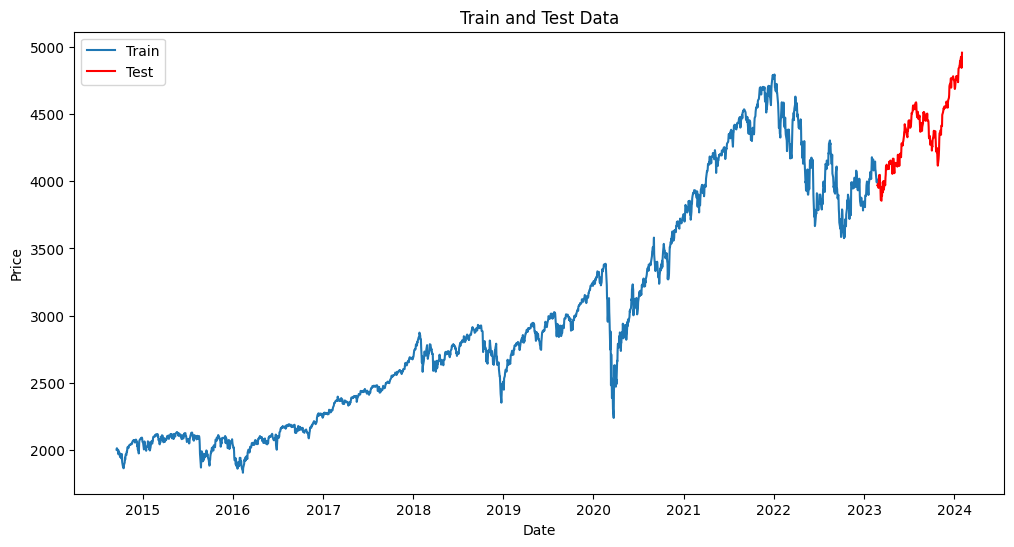

In [20]:
# Seperating Train / Test dataset by 9:1

train_size = int(len(SnP) * 0.9)
train = SnP.iloc[:train_size]
test = SnP.iloc[train_size:]

# Visualization of seperate

plt.figure(figsize=(12, 6))
plt.plot(train['Date'], train['Price'], label='Train')
plt.plot(test['Date'], test['Price'], c= 'r', label='Test')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Train and Test Data')
plt.legend()
plt.show()

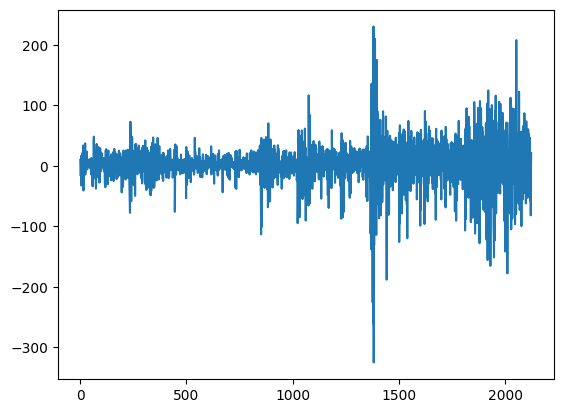


Results of Dickey-Fuller Test:
Test Statistic                -1.452119e+01
p-value                        5.520935e-27
#Lags Used                     9.000000e+00
Number of Observations Used    2.113000e+03
Critical Value (1%)           -3.433449e+00
Critical Value (5%)           -2.862909e+00
Critical Value (10%)          -2.567499e+00
dtype: float64
Is Stationary: Yes (reject)


In [21]:
# Differencing 1st 
diff_1 = train['Price'].diff().dropna()
plt.plot(diff_1)
plt.show()
print()
augmented_dickey_fuller_test(diff_1)

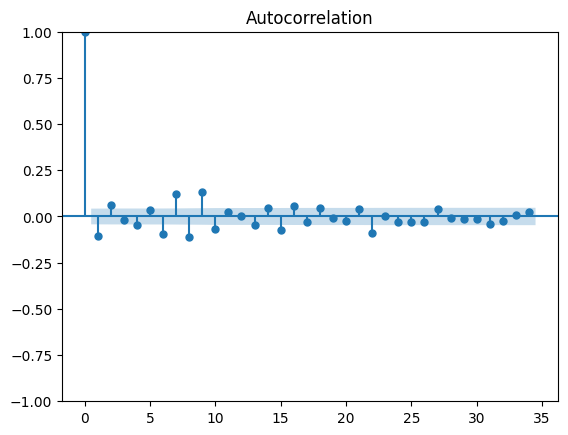

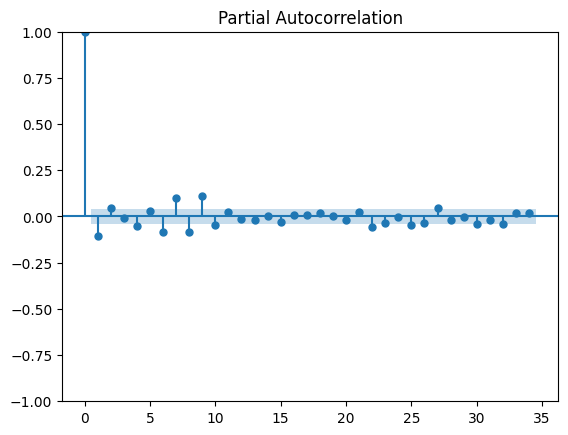

In [24]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

In [25]:
# Implementing ARIMA(1,2,1) model
model = ARIMA(train['Price'], order=(1,2,1))
results_ARIMA = model.fit()
print(results_ARIMA.summary())


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 2124
Model:                 ARIMA(1, 2, 1)   Log Likelihood              -10632.585
Date:                Tue, 13 Feb 2024   AIC                          21271.170
Time:                        15:54:01   BIC                          21288.150
Sample:                             0   HQIC                         21277.386
                               - 2124                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1078      0.010    -10.728      0.000      -0.128      -0.088
ma.L1         -1.0000      0.120     -8.304      0.000      -1.236      -0.764
sigma2      1312.5456    159.521      8.228      0.0

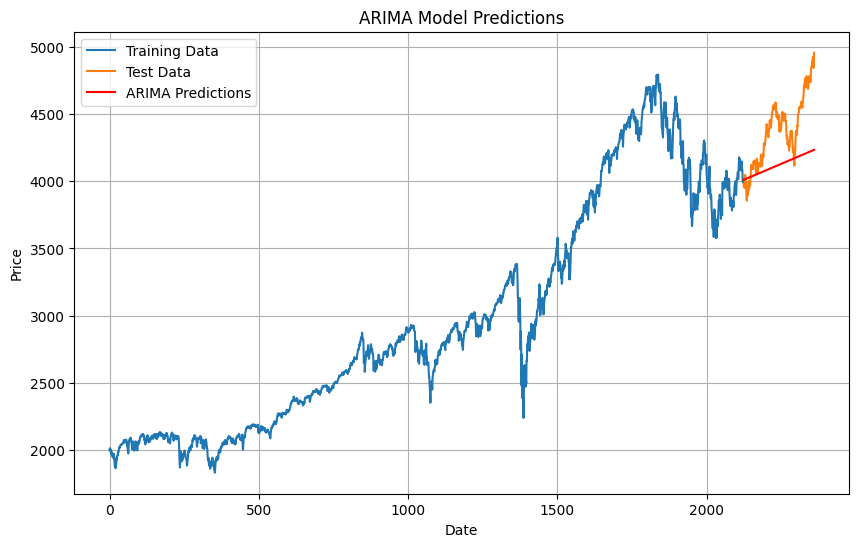

In [26]:
# ARIMA 모델로부터 예측 결과 얻기
predictions = results_ARIMA.forecast(steps=len(test))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Price'], label='Training Data')
plt.plot(test.index, test['Price'], label='Test Data')
plt.plot(test.index, predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()